# Prepare data and use deep learning model for PV production forecast
### - Fetch historical PV production data from an API endpoint
### - Fetch historical weather data and forecast from openmeto API:
### - Make predictions for a future time interval
### - Evaluate model accuracy
-----------------------------------



#### 1. Import or Install the needed libraries


In [64]:
import os
import logging
from datetime import datetime, timedelta
import pandas as pd
import pandas as pd_f

import matplotlib.pyplot as plt

import numpy as np
import requests
import requests_cache
from retry_requests import retry
import plotly.graph_objects as go

import torch
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import openmeteo_requests

import plotly.offline as pyo

import plotly.io as pio

cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


#### 2. Fetch the PV Production historical data from the API endpoint - http://209.38.208.230:8000/api/pvmeasurementdata/


In [65]:
# Load the data
start_date = '2024-12-01'
today = datetime.now().date() - timedelta(days=1)
end_date = today.strftime('%Y-%m-%d')
# custom end date
end_date = '2025-02-02'

ppe='590310600030911897'

url = f'http://209.38.208.230:8000/api/pvmeasurementdata/?start_date={start_date}&end_date={end_date}&ppe={ppe}'

# Get the data from the API
response = requests.get(url=url)


# Create a dataframe from the response

df_dam = pd.DataFrame(response.json())


# Clean the DataFrame
df_dam['production'] = df_dam['production'].replace(['-', 'n/e', 'N/A', 'NaN'], np.nan)
df_dam['production'] = df_dam['production'].astype(float)
df_dam['timestamp'] = pd.to_datetime(df_dam['timestamp'], errors='coerce', utc=True)
df_dam['timestamp'] = df_dam['timestamp'].dt.tz_convert('Europe/Warsaw')
df_dam['timestamp'] = df_dam['timestamp'].dt.tz_localize(None)  


# check for nans in the dataframe
if df_dam.isnull().values.any():
    print("Warning: NaNs detected in the DataFrame. Please fill or drop them.")

# drop all the columns instead of timestamp and production
df_dam = df_dam[['timestamp', 'production', 'latitude', 'longitude']]



In [66]:
# just for checking
print(df_dam.tail())

               timestamp  production latitude longitude
6044 2025-02-01 23:00:00         0.0  52.6395   16.6405
6045 2025-02-01 23:15:00         0.0  52.6395   16.6405
6046 2025-02-01 23:30:00         0.0  52.6395   16.6405
6047 2025-02-01 23:45:00         0.0  52.6395   16.6405
6048 2025-02-02 00:00:00         0.0  52.6395   16.6405


#### 3. Make some visualisations of the historical data

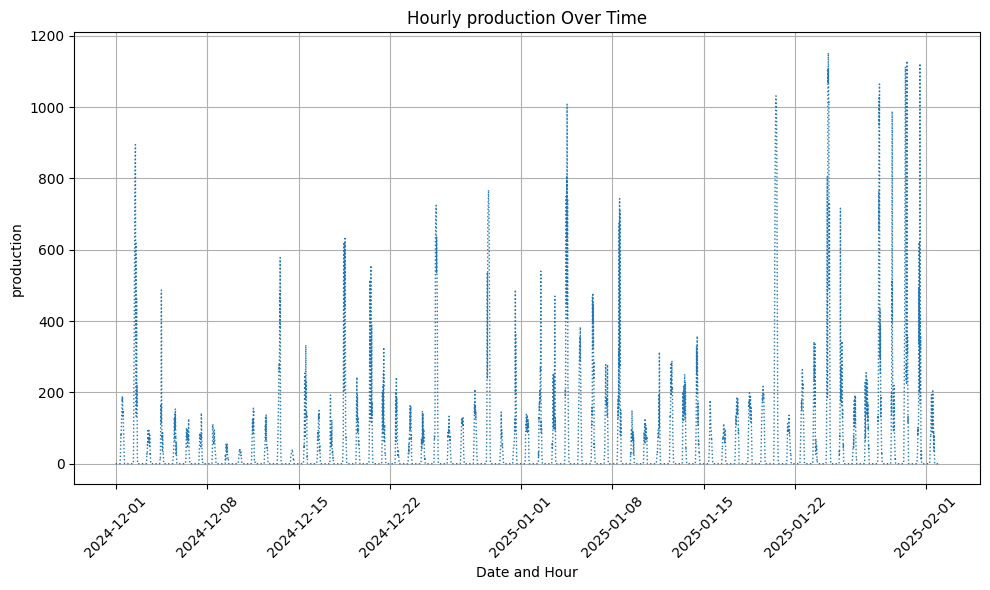

In [67]:
# Some initial data visualisations

start_week_number_analyzer = 1
end_week_number_analyzer = 52

df_dam_initial_chart = df_dam.copy()

df_dam_initial_chart['WeekNumber'] = df_dam_initial_chart['timestamp'].dt.isocalendar().week

# # Filter the data for the specified week range
df_weeks = df_dam_initial_chart[(df_dam_initial_chart['WeekNumber'] >= start_week_number_analyzer) & (df_dam_initial_chart['WeekNumber'] <= end_week_number_analyzer)]

# # Extract the date and hour for heatmap plotting
df_weeks['Date'] = df_weeks['timestamp'].dt.date
df_weeks['Hour'] = df_weeks['timestamp'].dt.hour

# Aggregate the prices by taking the average for each combination of Hour and Date
aggregated_data = df_weeks.groupby(['Hour', 'Date', 'WeekNumber'])['production'].mean().reset_index()

# Pivot the data to create a matrix suitable for heatmap
heatmap_data = aggregated_data.pivot(index='Hour', columns='Date', values='production')


# Create a heatmap
fig = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='Viridis'
))

# Update layout for better readability
fig.update_layout(
    title='DAM Market Price Heatmap',
    xaxis_title='Date',
    yaxis_title='Hour of Day',
    yaxis_nticks=24,
    xaxis_nticks=len(heatmap_data.columns),
    height=600
)

# Show the heatmap plot
fig.show()

# Create a line plot of hourly price over time
plt.figure(figsize=(10, 6))
plt.plot(df_weeks['timestamp'], df_weeks['production'], linestyle=':', linewidth=1)
plt.xlabel('Date and Hour')
plt.ylabel('production')
plt.title('Hourly production Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4. Fetch the historical weather data from open meto API - https://archive-api.open-meteo.com/v1/archive
#### The weather data includes: "temperature_2m", "cloud_cover", "cloud_cover_low", "wind_speed_10m", "direct_radiation", "diffuse_radiation", "global_tilted_irradiance", "is_day"
#### We have also some data cleaning as well as resempling the data of 15min

In [68]:
# Fetch the weather data
# # INCLUDE THE WEATHER FORECAST

def fetch_weather_data(start, end, url_weather = "https://archive-api.open-meteo.com/v1/archive"):

	lat = float(df_dam['latitude'].iloc[0])
	long = float(df_dam['longitude'].iloc[0])
	
	# start = datetime.strptime(end_date, '%Y-%m-%d')
	params = {
		"latitude": lat,
		"longitude": long,
		"start_date":start,	
		"end_date": end,
		"hourly": ["temperature_2m", "cloud_cover", "cloud_cover_low", "wind_speed_10m", "direct_radiation", "diffuse_radiation", "global_tilted_irradiance", "is_day"],
		"tilt": 30
	}
	responses = openmeteo.weather_api(url_weather, params=params)
	response_weather = responses[0]


	hourly = response_weather.Hourly()
	hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
	hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
	hourly_cloud_cover_low = hourly.Variables(2).ValuesAsNumpy()
	hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
	hourly_direct_radiation = hourly.Variables(4).ValuesAsNumpy()
	hourly_diffuse_radiation = hourly.Variables(5).ValuesAsNumpy()
	hourly_global_tilted_irradiance = hourly.Variables(6).ValuesAsNumpy()
	hourly_is_day = hourly.Variables(7).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}

	hourly_data["temperature_2m"] = hourly_temperature_2m
	hourly_data["cloud_cover"] = hourly_cloud_cover
	hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
	hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
	hourly_data["direct_radiation"] = hourly_direct_radiation
	hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
	hourly_data["global_tilted_irradiance"] = hourly_global_tilted_irradiance
	hourly_data["is_day"] = hourly_is_day

	hourly_dataframe = pd.DataFrame(data = hourly_data)

	# Set index to datetime
	hourly_dataframe["date"] = pd.to_datetime(hourly_dataframe["date"])
	hourly_dataframe.set_index("date", inplace=True)

	# Resample to 15-minute intervals using linear interpolation
	resampled_df = hourly_dataframe.resample("15T").ffill()

	# Reset index to have 'date' as a column again
	resampled_df.reset_index(inplace=True)

	resampled_df["date"] = resampled_df["date"].dt.tz_localize(None)
	
	return resampled_df



#### 5. Merge and preprocess the historical PV measurement data as well as the Weather data 

In [69]:
# Merge the weather data with the production data

print(start_date, end_date)

resampled_df = fetch_weather_data(start_date, end_date)

combined_weather_and_df_dam = pd.merge(df_dam, resampled_df, how='inner', left_on='timestamp', right_on='date')

# Drop the duplicate date column
combined_weather_and_df_dam.drop(columns='date', inplace=True)

# Drop Latitude and Longitude columns
combined_weather_and_df_dam.drop(columns=['latitude', 'longitude'], inplace=True)

# Drop the rows with missing values
combined_weather_and_df_dam.dropna(inplace=True)

combined_weather_and_df_dam = combined_weather_and_df_dam.iloc[:-1]

print(combined_weather_and_df_dam.tail())

2024-12-01 2025-02-02
               timestamp  production  temperature_2m  cloud_cover  \
6043 2025-02-01 22:45:00         0.0          1.1805         63.0   
6044 2025-02-01 23:00:00         0.0          0.9305         74.0   
6045 2025-02-01 23:15:00         0.0          0.9305         74.0   
6046 2025-02-01 23:30:00         0.0          0.9305         74.0   
6047 2025-02-01 23:45:00         0.0          0.9305         74.0   

      cloud_cover_low  wind_speed_10m  direct_radiation  diffuse_radiation  \
6043             60.0        5.920878               0.0                0.0   
6044             70.0        5.720489               0.0                0.0   
6045             70.0        5.720489               0.0                0.0   
6046             70.0        5.720489               0.0                0.0   
6047             70.0        5.720489               0.0                0.0   

      global_tilted_irradiance  is_day  
6043                       0.0     0.0  
6044        

C:\Users\Georgi\AppData\Local\Temp\ipykernel_13256\3547839201.py:55: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



#### 6. Prepare the future covariates for the length of the prediction interval - this includes the weather forecast with all weather parameters for the length of the future prediction 

In [70]:
# Prepare future covariates
# Fetch the /historical/ forecast data

start_date_val = end_date
end_date_val = (datetime.strptime(start_date_val, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
# end_date_val = end_date_val.strftime('%Y-%m-%d')

# start_date_val = (datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=5)).strftime('%Y-%m-%d')
# end_date_val = (datetime.strptime(start_date_val, '%Y-%m-%d') + timedelta(days=5)).strftime('%Y-%m-%d')

print(start_date_val, end_date_val)

forecast_df = fetch_weather_data(start_date_val, end_date_val, url_weather = "https://api.open-meteo.com/v1/forecast")

# Rename Date to timestamp
forecast_df.rename(columns={'date': 'timestamp'}, inplace=True)

forecast_df["item_id"] = "series_1"

forecast_df = forecast_df.iloc[:96]

future_covariates = TimeSeriesDataFrame.from_data_frame(
    forecast_df,
    id_column="item_id",
    timestamp_column="timestamp"
)

known_covariates = ["temperature_2m", "cloud_cover", "cloud_cover_low", "wind_speed_10m", "direct_radiation", "diffuse_radiation", "global_tilted_irradiance", "is_day"]

print(len(future_covariates))



2025-02-02 2025-02-03
96


C:\Users\Georgi\AppData\Local\Temp\ipykernel_13256\3547839201.py:55: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



#### 6. Prepare the needed for the autugluon ML framework. Set the model - "DeepAR" as well as some hyperparameters and prediction length

In [1]:
# Prepare data for the Autogluon
from lightning.pytorch.callbacks import EarlyStopping

combined_weather_and_df_dam["item_id"] = "series_1"

target_column = 'production'  

#Convert DataFrame to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_data_frame(
    combined_weather_and_df_dam,
    id_column="item_id",
    timestamp_column="timestamp"
)

# model_path = "AutogluonModels/ag-20250207_104540/"  
# predictor = TimeSeriesPredictor.load(model_path)


#Initialize the predictor
predictor = TimeSeriesPredictor(
    target=target_column,    
    prediction_length=96,
    freq='15min',
    known_covariates_names=known_covariates
)

#Fit the predictor with cross-validation
results = predictor.fit(
    train_data=train_data,    
    time_limit=600,  # 20 min
    presets='fast_training',
    eval_metric="MASE",
        hyperparameters={       
        "DeepAR": {
            "num_evals": 5,
            "epochs": 100,
            "callbacks": [EarlyStopping(monitor="val_loss", patience=20, mode="min")]    
                   
                   },
            
    },
    # hyperparameters={
    #     "DeepAR": {
    #         # You can specify DeepAR-specific hyperparameters here
    #         # For example:
    #         "context_length": 576,
    #         "num_layers": 3,
    #         "hidden_size": 96,
    #         "dropout_rate": 0.1,
    #         "learning_rate": 1e-3
    #     }
    # },  
    )

c:\Users\Georgi\test_gluon\gluon_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'combined_weather_and_df_dam' is not defined

In [ ]:
train_data.tail()
# leaderboard = predictor.leaderboard()
# print(leaderboard)

production  temperature_2m  cloud_cover  \
item_id  timestamp                                                      
series_1 2025-01-31 22:45:00         0.0          2.9305        100.0   
         2025-01-31 23:00:00         0.0          3.2305        100.0   
         2025-01-31 23:15:00         0.0          3.2305        100.0   
         2025-01-31 23:30:00         0.0          3.2305        100.0   
         2025-01-31 23:45:00         0.0          3.2305        100.0   

                              cloud_cover_low  wind_speed_10m  \
item_id  timestamp                                              
series_1 2025-01-31 22:45:00            100.0       17.518356   
         2025-01-31 23:00:00            100.0       17.485960   
         2025-01-31 23:15:00            100.0       17.485960   
         2025-01-31 23:30:00            100.0       17.485960   
         2025-01-31 23:45:00            100.0       17.485960   

                              direct_radiation  diffuse_radiation  \
item_id  timestamp                                                  
series_1 2025-01-31 22:45:00               0.0                0.0   
         2025-01-31 23:00:00               0.0                0.0   
         2025-01-31 23:15:00               0.0                0.0   
         2025-01-31 23:30:00               0.0                0.0   
         2025-01-31 23:45:00               0.0                0.0   

                              global_tilted_irradiance  is_day  
item_id  timestamp                                              
series_1 2025-01-31 22:45:00                       0.0     0.0  
         2025-01-31 23:00:00                       0.0     0.0  
         2025-01-31 23:15:00                       0.0     0.0  
         2025-01-31 23:30:00                       0.0     0.0  
         2025-01-31 23:45:00                       0.0     0.0

In [ ]:
# cv_results = predictor.fit_summary()
# print(cv_results)

****************** Summary of fit() ******************
Estimated performance of each model:
    model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.554239       2.149333          543.56477          1
Number of models trained: 1
Types of models trained:
{'MultiWindowBacktestingModel'}
****************** End of fit() summary ******************
{'model_types': {'DeepAR': 'MultiWindowBacktestingModel'}, 'model_performance': {'DeepAR': -0.5542389137556468}, 'model_best': 'DeepAR', 'model_paths': {'DeepAR': ['DeepAR']}, 'model_fit_times': {'DeepAR': 543.564769744873}, 'model_pred_times': {'DeepAR': 2.1493330001831055}, 'model_hyperparams': {'DeepAR': {'context_length': 100, 'num_layers': 2, 'hidden_size': 40}}, 'leaderboard':     model  score_val  pred_time_val  fit_time_marginal  fit_order
0  DeepAR  -0.554239       2.149333          543.56477          1}


In [13]:
import os
import json

# # Save the model
# model_info = predictor.info()
# path_data = model_info.get('path', None)
# folder_name = 'AutoglounModels'
# split = path_data.split('AutogluonModels\\')
# if len(split) > 1:

# record the model path into models_path_data.json
models_path_data = {'model_path': 'AutogluonModels/ag-20250224_114806', 'ppe': '590310600030911897'}
if os.path.exists('models_path_data.json'):
    with open('models_path_data.json', 'r') as f:
        data = json.load(f)
else:
    data = []

if models_path_data not in data:
    data.append(models_path_data)

# Write the updated list back to the file
with open('models_path_data.json', 'w') as f:
    json.dump(data, f, indent=4)





In [59]:
combined_weather_and_df_dam["item_id"] = "series_1"

#Convert DataFrame to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame.from_data_frame(
    combined_weather_and_df_dam,
    id_column="item_id",
    timestamp_column="timestamp"
)
print(train_data.tail())

                              production  temperature_2m  cloud_cover  \
item_id  timestamp                                                      
series_1 2025-02-01 22:45:00         0.0          1.1805         63.0   
         2025-02-01 23:00:00         0.0          0.9305         74.0   
         2025-02-01 23:15:00         0.0          0.9305         74.0   
         2025-02-01 23:30:00         0.0          0.9305         74.0   
         2025-02-01 23:45:00         0.0          0.9305         74.0   

                              cloud_cover_low  wind_speed_10m  \
item_id  timestamp                                              
series_1 2025-02-01 22:45:00             60.0        5.920878   
         2025-02-01 23:00:00             70.0        5.720489   
         2025-02-01 23:15:00             70.0        5.720489   
         2025-02-01 23:30:00             70.0        5.720489   
         2025-02-01 23:45:00             70.0        5.720489   

                              di

In [60]:
# Prepare the new covariates

start_date_val = '2025-02-02'
end_date_val = '2025-02-03'

print(start_date_val, end_date_val)

forecast_df = fetch_weather_data(start_date_val, end_date_val, url_weather = "https://api.open-meteo.com/v1/forecast")

# Rename Date to timestamp
forecast_df.rename(columns={'date': 'timestamp'}, inplace=True)

forecast_df["item_id"] = "series_1"

forecast_df = forecast_df.iloc[:96]

future_covariates = TimeSeriesDataFrame.from_data_frame(
    forecast_df,
    id_column="item_id",
    timestamp_column="timestamp"
)

known_covariates = ["temperature_2m", "cloud_cover", "cloud_cover_low", "wind_speed_10m", "direct_radiation", "diffuse_radiation", "global_tilted_irradiance", "is_day"]

print(len(future_covariates))


2025-02-02 2025-02-03
96


C:\Users\Georgi\AppData\Local\Temp\ipykernel_13256\3547839201.py:55: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



In [61]:
# make the predictions
print(len(future_covariates))
predictions = predictor.predict(data=train_data, known_covariates=future_covariates)
# predictions = predictor.predict(data=train_data, known_covariates=future_covariates)
predictions[predictions < 0] = 0
print(predictions)

96
                              mean  0.1  0.2  0.3  0.4  0.5       0.6  \
item_id  timestamp                                                      
series_1 2025-02-02 00:00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
         2025-02-02 00:15:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
         2025-02-02 00:30:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
         2025-02-02 00:45:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
         2025-02-02 01:00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
...                            ...  ...  ...  ...  ...  ...       ...   
         2025-02-02 22:45:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
         2025-02-02 23:00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
         2025-02-02 23:15:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
         2025-02-02 23:30:00   0.0  0.0  0.0  0.0  0.0  0.0  0.501280   
         2025-02-02 23:45:00   0.0  0.0  0.0  0.0  0.0  0.0  0.708918   

                                   0.7       0.

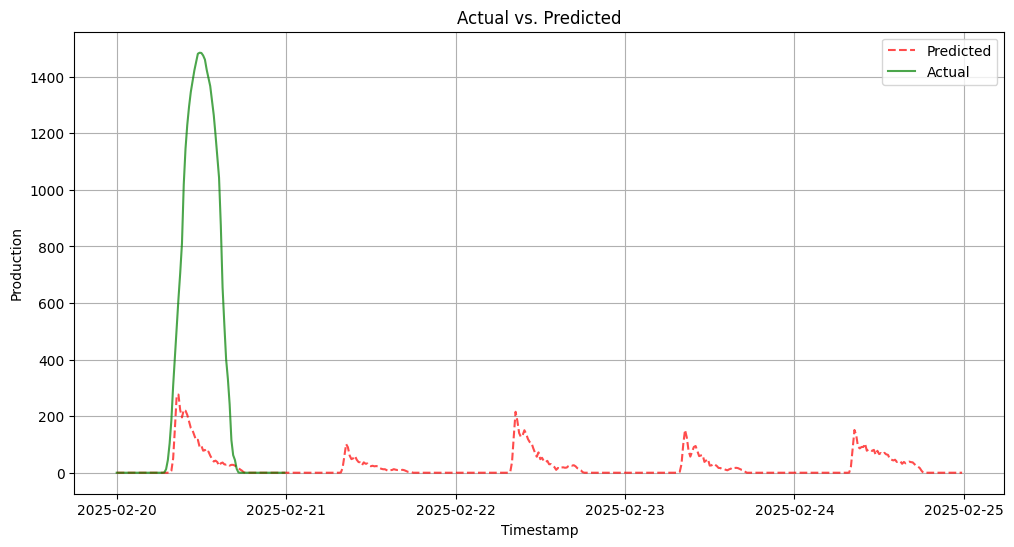

In [67]:
# Evaluate the model with known data of production for the predicted period:

start_date_val = end_date
end_date_val = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=5)
end_date_val = end_date_val.strftime('%Y-%m-%d') 


url_val = f'http://209.38.208.230:8000/api/pvmeasurementdata/?start_date={start_date_val}&end_date={end_date_val}&ppe={ppe}'
response_val = requests.get(url=url_val)
# Create a dataframe from the response
df_validation = pd.DataFrame(response_val.json())

df_validation['timestamp'] = pd.to_datetime(df_validation['timestamp'], errors='coerce', utc=True)

df_validation['timestamp'] = df_validation['timestamp'].dt.tz_convert('Europe/Warsaw')

df_validation['timestamp'] = df_validation['timestamp'].dt.tz_localize(None)  # Remove timezone

# prepare the prediction df
df_pred = predictions.reset_index()


plt.figure(figsize=(12, 6))

# Plot predicted mean
plt.plot(df_pred["timestamp"], df_pred["mean"], label="Predicted", linestyle='--', color="red", alpha=0.7)

plt.plot(df_validation["timestamp"], df_validation["production"], 
             label="Actual", linestyle='-', color="green", alpha=0.7)

# Optionally plot prediction intervals
plt.xlabel("Timestamp")
plt.ylabel("Production")
plt.title("Actual vs. Predicted")
plt.legend()
plt.grid()
plt.show()


In [212]:
print(df_pred[['timestamp','mean']])


              timestamp      mean
0   2025-02-06 00:00:00  1.070578
1   2025-02-06 00:15:00  0.873384
2   2025-02-06 00:30:00  1.018459
3   2025-02-06 00:45:00  1.078771
4   2025-02-06 01:00:00  1.058189
..                  ...       ...
187 2025-02-07 22:45:00  0.884316
188 2025-02-07 23:00:00  0.843993
189 2025-02-07 23:15:00  1.032271
190 2025-02-07 23:30:00  1.196080
191 2025-02-07 23:45:00  0.999230

[192 rows x 2 columns]
